# DistilBERT for fake news detection


Make sure that you are using GPU

In [1]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

You can see the type of gpu available for you:

In [2]:
!nvidia-smi

Thu Oct 20 10:06:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Load the data

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
root = 'drive/My Drive/TFG/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
MULTIMODAL_ONLY = True # if False, we will load all the
nameFile = 'multimodal_'
if not MULTIMODAL_ONLY:
    nameFile ='all_'

NUM_CLASSES = 6 # 2, 3 or 6

labels = []
if NUM_CLASSES == 2:
    labels= ["True", "False"]
    reorder= ["True", "False"]

elif NUM_CLASSES == 3:
    labels= ["True", "Fake contains True", "False"]
    reorder= ["True", "Fake contains True", "False"]

elif NUM_CLASSES == 6:
    labels= ["True", "Satire/Parody", "Misleading Content", "Imposter Content", "False Connection", "Manipulated Content"]
    reorder= ["True", "Satire", "Misleading", "Imposter", "False", "Manipulated"]

In [5]:
import pandas as pd
train = pd.read_csv(root+"data/fakeddit/" + nameFile+ "train.tsv", sep='\t')
val  = pd.read_csv(root+"data/fakeddit/" + nameFile+ "validate.tsv", sep='\t')
test  = pd.read_csv(root+"data/fakeddit/" + nameFile+ "test_public.tsv", sep='\t')

print("Dataset: ", nameFile)
print('size training: ', len(train))
print('size validation: ', len(val))
print('size test: ', len(test))


Dataset:  multimodal_
size training:  564000
size validation:  59342
size test:  59319


In [6]:
train.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [7]:
import numpy as np
reduction = 10 #100, 10 or 1

print("reduction applied: ", reduction)


print(f"Training patterns before reduction: {len(train)}")
train = train.sample(int(len(train)/reduction), random_state=12345)
print(f"Training patterns after reduction:  {len(train)}")

print(f"Validation patterns before reduction: {len(val)}")
val = val.sample(int(len(val)/reduction), random_state=12345)
print(f"Validation patterns after reduction:  {len(val)}")

print(f"Test patterns before reduction: {len(test)}")
test = test.sample(int(len(test)/reduction), random_state=12345)
print(f"Test patterns after reduction:  {len(test)}")

reduction applied:  10
Training patterns before reduction: 564000
Training patterns after reduction:  56400
Validation patterns before reduction: 59342
Validation patterns after reduction:  5934
Test patterns before reduction: 59319
Test patterns after reduction:  5931


Visualize data

['True', 'Satire/Parody', 'Misleading Content', 'Imposter Content', 'False Connection', 'Manipulated Content']


Text(0.5, 1.0, 'Testing Dataset')

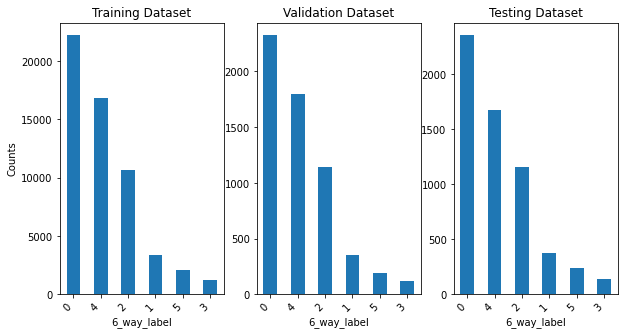

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3 , figsize=(10,5))
print(labels)
train.value_counts(str(NUM_CLASSES)+'_way_label').plot(kind='bar', ax=axes[0])
plt.sca(axes[0])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')

val.value_counts(str(NUM_CLASSES)+'_way_label').plot(kind='bar', ax=axes[1])
plt.sca(axes[1])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Validation Dataset')

test.value_counts(str(NUM_CLASSES)+'_way_label').plot(kind='bar', ax=axes[2])
plt.sca(axes[2])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Testing Dataset')

Obtain the maximum length (tokens) of the titles (you only see in the training and validation datasets):

In [9]:
x_train=train["clean_title"]
x_val=val["clean_title"]
x_test=test["clean_title"]


y_train = train[str(NUM_CLASSES)+'_way_label']
y_val = val[str(NUM_CLASSES)+'_way_label']
y_test = test[str(NUM_CLASSES)+'_way_label']

We need to know the maximum length (based on number of tokens) of the input sequences (from training and validation dataset) to set the parameter MAX_LENGTH. 
If the maximum length is greater than 512 (maximum lenght for BERT), we will set MAX_LENGTH to 512.

In [10]:
tokens=x_train.apply(lambda x: x.split())
lengths=tokens.apply(lambda x: len(x))
max_train = max(lengths)
# print(max(lengths))

tokens=x_val.apply(lambda x: x.split())
lengths=tokens.apply(lambda x: len(x))
max_val = max(lengths)
# print(max(lengths))

MAX_LENGTH = max(max_train, max_val)
print("The maximum length of the input sequences is {} tokens".format(MAX_LENGTH))

MAX_LENGTH=min(512,MAX_LENGTH)
print("MAX_LENGTH = {}".format(MAX_LENGTH))


The maximum length of the input sequences is 127 tokens
MAX_LENGTH = 127


Install library transformers

In [11]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.0 MB/s 
     |████████████████████████████████| 7.6 MB 48.8 MB/s 
     |████████████████████████████████| 163 kB 68.4 MB/s 


Load distilbert

In [12]:
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from tqdm import tqdm # Progress Bar
import numpy as np


MODEL_NAME = 'distilbert-base-cased'


tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       padding='max_length',
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Tokenize datasets (it takes a long time to load the training dataset):

In [13]:
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)
X_val = tokenize(x_val, tokenizer)

100%|██████████| 5934/5934 [00:01<00:00, 3604.45it/s]


In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
warnings.filterwarnings("ignore")

Define the model

In [15]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 127)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 127)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 127, 768),                                                   
                                 hidden_states=((No                                           

In [16]:
import os

### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

Define callbacks

In [17]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10, #10
                    batch_size= 16, #16
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
3525/3525 [==============================] - 335s 93ms/step - loss: 0.9105 - accuracy: 0.6715 - val_loss: 0.7776 - val_accuracy: 0.7091 - lr: 0.0010
Epoch 2/10
 846/3525 [======>.......................] - ETA: 3:47 - loss: 0.7780 - accuracy: 0.7192

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)


In [ ]:
def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [ ]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights


In [ ]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def print_cf2(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels,columns=[0,1,2]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2], labels, rotation=45)
    plt.ylabel("True Value")
    plt.show()


print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf2(y_test, y_hat)


In [ ]:
print(classification_report(y_test, y_hat, target_names=labels))
